In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, mean_squared_error, plot_roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm 

from aiutils import classification_rate, load, save, softmax
from config import GameConfig
from enums import StartingSplit, FeatureType
from env import DefaultEnvironment, Environment
from mlp import PredictorMLP
from mlprunner import train_mlp
from player import load_players, RolloutPlayer
from predictor import sample_training_batch, test_mlp
from rollout import LogisticRegressionEnsembleRollout
from state import DecisionResponse, DecisionState, State, ReducedStateFeature
from supply import Supply

In [3]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')

## Logistic Regression: Manual Weight Setting ##

We expect 100% classification accuracy on terminal states when the weights are equal to the VP value of the corresponding cards. 

In [4]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, prosperity=False, num_players=2, feature_type=FeatureType.ReducedFeature, sandbox=True)
players = load_players(['R', 'R'], models=None, train=True)

In [5]:
dataset_name = 'test-r-r-1k-terminal'
data_path = os.path.join(project_root, 'datasets', dataset_name)

In [6]:
X, y = sample_training_batch(1000, -1, config, players)  

100%|██████████| 1000/1000 [00:26<00:00, 37.27it/s]


In [7]:
save(data_path, [X, y])

In [5]:
raw_data = load(data_path)
X, y = raw_data[0], raw_data[1]

In [7]:
# What are the class priors in the training sample? 
classes, rates = classification_rate(y)
classes, rates

(array([-1,  0,  1]), array([0.3280769 , 0.24600685, 0.42591625]))

In [6]:
train_y = y.copy()
train_y[train_y < 0] = 0

In [11]:
idxs = {'Copper': 0, 'Curse': 1, 'Estate': 2, 'Duchy': 3, 'Province': 4, 'Silver': 5, 'Gold': 6}
cards = list(idxs.keys())

In [54]:
weights = np.zeros(config.feature_size)
weights[7 + 1] = -1
weights[7 + 2] = 1
weights[7 + 3] = 3
weights[7 + 4] = 6
weights[14 + 1] = 1
weights[14 + 2] = -1
weights[14 + 3] = -3
weights[14 + 4] = -6
weights

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  3.,  6.,  0.,
        0.,  0.,  1., -1., -3., -6.,  0.,  0.])

In [55]:
test_model = LogisticRegression()
test_model.coef_ = np.array([weights])
test_model.intercept_ = 0
test_model.classes_ = np.array([0, 1])
test_model.coef_

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  3.,  6.,  0.,
         0.,  0.,  1., -1., -3., -6.,  0.,  0.]])

In [56]:
test_model.score(X, train_y)

1.0

In [57]:
roc_auc_score(train_y, test_model.predict_proba(X)[:, 1])

1.0

## Self-play Logistic Model Training ##

In [20]:
from buyagenda import BigMoneyBuyAgenda
from constants import BUY
from player import GreedyLogisticPlayer, HeuristicPlayer
from rolloutrunner import train_elog

In [21]:
from simulations import simulate

In [17]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)

In [8]:
# Warm-start
model_name = 'bm-bm-logistic-pred-1k-first-province'
model_path = os.path.join(model_dir, model_name)
model = load(model_path)

In [9]:
rollout = LogisticRegressionEnsembleRollout(tau=0.001, train=True)
rollout.models[8] = model

In [12]:
filtered_X_idxs = [(i, x) for i, x in enumerate(X) if x[idxs['Province']] > 6]
filtered_X_idxs = [list(t) for t in zip(*filtered_X_idxs)]
filtered_X = filtered_X_idxs[1]
filtered_y = train_y[filtered_X_idxs[0]]
assert len(filtered_X) == len(filtered_y)
len(filtered_y)

17506

In [13]:
classification_rate(filtered_y)

(array([0, 1]), array([0.58060094, 0.41939906]))

In [14]:
for i, x in enumerate(filtered_X): 
    rollout.buffers[8].store(x, filtered_y[i])

In [15]:
config = GameConfig(split=StartingSplit.StartingRandomSplit, prosperity=False, num_players=2, feature_type=FeatureType.ReducedFeature, sandbox=True)
player = RolloutPlayer(rollout=rollout)
players = [player, player]

In [18]:
env = DefaultEnvironment(config, players, logger=logger)

In [22]:
logger.setLevel(logging.ERROR)
train_elog(env, 10000, 1000)

 70%|██████▉   | 6999/10000 [12:57<24:52,  2.01it/s]ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
 80%|███████▉  | 7999/10000 [21:51<13:30,  2.47it/s]ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
 90%|████████▉ | 8999/10000 [31:08<07:50,  2.13it/s]ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
100%|█████████▉| 9999/10000 [40:39<00:00,  1.89it/s]ERROR:This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0
ERROR:This solver needs samples of at least

In [27]:
player.train = False
players = [HeuristicPlayer(BigMoneyBuyAgenda()), player]
# players = [player, HeuristicPlayer(BigMoneyBuyAgenda())]
env = DefaultEnvironment(config, players, logger=logger)
logger.setLevel(logging.ERROR)
# logger.setLevel(BUY)
simulate(env, 100, None)

100%|██████████| 100/100 [00:01<00:00, 68.90it/s]===SUMMARY===
{0: 98, 1: 2, 'ProvinceWins': 100, 'Ties': 0}



<AxesSubplot:>

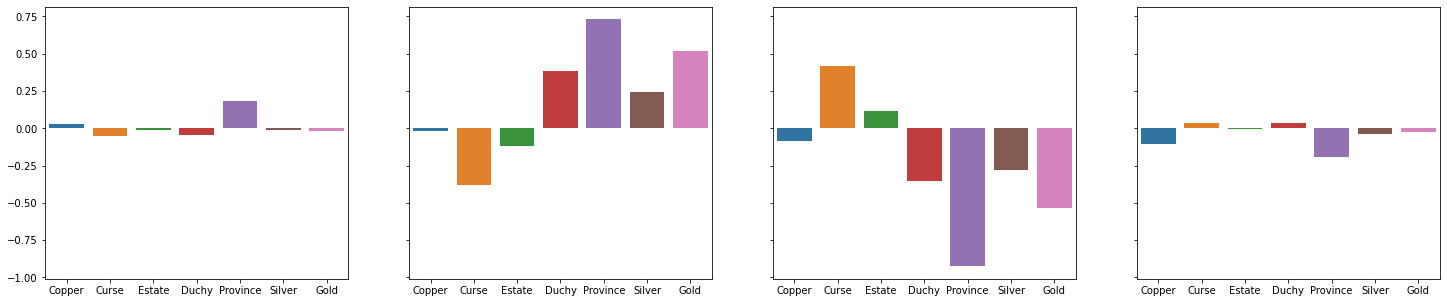

In [25]:
plot_model = player.rollout.models[6]

agent_weights = plot_model.coef_[0][7:14]
opp_weights = plot_model.coef_[0][14:]
supply_weights = plot_model.coef_[0][:7]
player_weight_diffs = agent_weights + opp_weights
cards = list(idxs.keys())

f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])

## Predictor MLP Training ##

In [11]:
model = PredictorMLP(config.feature_size, (config.feature_size + 1) // 2, 1)
criterion = nn.BCELoss()

In [12]:
model_name = 'bm-bm-mlp-pred-bce-first-province-1k-100'
model_path = os.path.join(model_dir, model_name)

In [16]:
train_mlp(filtered_X, filtered_y, model, criterion, epochs=100, save_epochs=10, model_name=model_name, path=os.path.join(model_dir, model_name))

100%|██████████| 100/100 [21:24<00:00, 12.84s/it]


In [439]:
y1 = np.array(y, dtype=np.float32)
train_mlp(X, y1, model, criterion, epochs=100, save_epochs=10, model_name=model_name, path=os.path.join(model_dir, model_name))

100%|██████████| 100/100 [21:20<00:00, 12.81s/it]


In [71]:
y_pred = model(torch.tensor(X).cuda()).detach().cpu().numpy()
y_labels = np.array(train_y).reshape(y_pred.shape)

TypeError: 'LogisticRegression' object is not callable

In [331]:
output = (y_pred > 0.5)
correct = (output == y_labels).sum() 
acc  = correct / len(y_labels)

In [332]:
acc

0.7853855651588282

In [87]:
mean_squared_error(y_pred, y_labels)

0.11117749924175713

## Logistic Model Training ##

Let's try a simpler logistic regression model.

In [14]:
from sklearn.linear_model import LogisticRegression

In [94]:
C = 10
max_iter = 10e5
model = LogisticRegression(max_iter=max_iter, C=C, penalty='none')

In [95]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')
model_name = 'bm-bm-logistic-pred-1k-first-province'
model_path = os.path.join(model_dir, model_name)
model_path

'/home/justiny/Documents/Projects/PyDominion/models/bm-bm-logistic-pred-1k-first-province'

In [120]:
model = load(model_path)
model

LogisticRegression(C=10, max_iter=1000000.0)

In [309]:
model = model.fit(X, train_y)
model.score(X, train_y)

0.6270836963466342

In [96]:
model = model.fit(filtered_X, filtered_y)
train_probs = model.predict_proba(filtered_X)[:, 1]
model.score(filtered_X, filtered_y), roc_auc_score(filtered_y, train_probs)

(0.5930305626963724, 0.5912522237300457)

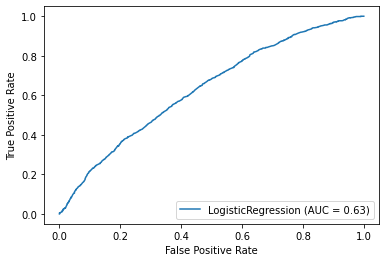

In [33]:
plot_roc_curve(model, filtered_X, filtered_y)

In [17]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [311]:
agent_weights = model.coef_[0][7:14]
opp_weights = model.coef_[0][14:]
supply_weights = model.coef_[0][:7]
player_weight_diffs = agent_weights + opp_weights
cards = list(idxs.keys())

<AxesSubplot:>

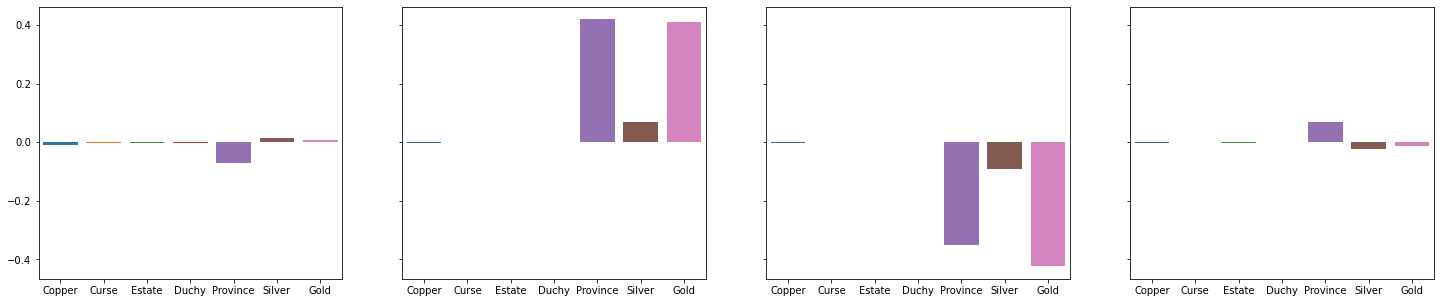

In [312]:
f, axes = plt.subplots(1,4, figsize=(25, 5), sharey='all')
sns.barplot(x=cards, y=supply_weights, ax=axes[0])
sns.barplot(x=cards, y=agent_weights, ax=axes[1])
sns.barplot(x=cards, y=opp_weights, ax=axes[2])
sns.barplot(x=cards, y=player_weight_diffs, ax=axes[3])

In [97]:
import pickle

In [98]:
pickle.dump(model, open(model_path, 'wb'))

## Logistic Model Testing ##
Let's test the logistic regression model.

In [121]:
test_config = GameConfig(split=StartingSplit.StartingRandomSplit, prosperity=False, num_players=2, feature_type=FeatureType.ReducedFeature, sandbox=True)
test_players = load_players(['R', 'R'], models=None, train=False)

In [122]:
test_X, test_y = sample_training_batch(1000, -1, test_config, test_players)

100%|██████████| 1000/1000 [00:35<00:00, 28.06it/s]


In [123]:
test_classes, test_rates = classification_rate(test_y)
test_classes, test_rates

(array([ 1, -1,  0]), array([0.485, 0.448, 0.067]))

In [124]:
wl_test_y = test_y.copy() 
wl_test_y[wl_test_y < 0] = 0

In [125]:
model.score(test_X, wl_test_y)

0.642

In [126]:
test_probs, pred_classes = model.predict_proba(test_X)[:, 1], model.predict(test_X)

In [156]:
thresh = .99999999999
test_pred_classes_post_threshold = [1 if p > thresh else 0 for p in test_probs]
sum(wl_test_y == test_pred_classes_post_threshold) / len(wl_test_y)

0.945

In [127]:
roc_auc_score(wl_test_y, test_probs), f1_score(wl_test_y, pred_classes)

(0.9908597737964168, 0.7304216867469879)

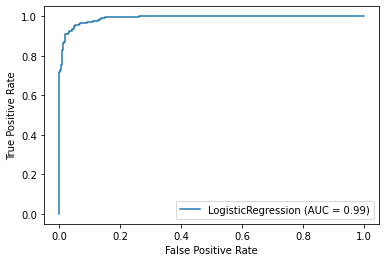

In [128]:
plot_roc_curve(model, test_X, wl_test_y)

In [159]:
test_X_classes = model.predict(test_X)
err = test_X[test_X_classes != wl_test_y]
len(err) / len(test_X_classes)

0.358

In [160]:
i=3
err[i][7:14], err[i][14:], model.predict_proba([err[i]]), wl_test_y[i]

(array([24.,  0.,  6.,  4.,  0., 19.,  6.], dtype=float32),
 array([27.,  0.,  8.,  4.,  0., 21.,  2.], dtype=float32),
 array([[1.2006001e-07, 9.9999988e-01]]),
 0)

In [250]:
X_exhausted_duchies = list(filter(lambda x: x[3] < 1, test_X))
len(X_exhausted_duchies)

1

In [251]:
X_exhausted_duchies[0]state

array([46., 10.,  5.,  0.,  0., 28., 20.,  7.,  0.,  4.,  3.,  5.,  6.,
        6.,  7.,  0.,  5.,  5.,  3.,  6.,  4.], dtype=float32)

In [242]:
X_with_estates = list((i, x) for i, x in enumerate(test_X) if x[7+2] > 3 or x[14+2] > 3)

In [244]:
y_with_estates_idxs = [i for i, x in X_with_estates]

In [1]:
y_with_estates = wl_test_y[y_with_estates_idxs]
sum(y_with_estates == 0) / len(y_with_estates)

NameError: name 'wl_test_y' is not defined

In [243]:
len(X_with_estates)

78

## MLP Predictor Testing ##


In [216]:
project_root = '/home/justiny/Documents/Projects/PyDominion'
model_dir = os.path.join(project_root, 'models')
model_name = 'r-r-mlp-pred-bce-10k-50--1'
model_path = os.path.join(model_dir, model_name)
model_path

'/home/justiny/Documents/Projects/PyDominion/models/r-r-mlp-pred-bce-10k-50--1'

In [217]:
model = torch.load(model_path, map_location='cpu')

In [218]:
y_test_pred = model(torch.tensor(test_X)).detach().cpu().numpy()
y_test_labels = np.array(wl_test_y).reshape(y_test_pred.shape)

In [220]:
output = (y_test_pred > 0.5)
correct = (output == y_test_labels).sum() 
incorrect_flags = (output != y_test_labels).flatten()
incorrect = test_X[incorrect_flags]
incorrect_prob = y_test_pred[incorrect_flags]
acc  = correct / len(y_test_labels)

In [221]:
acc

0.986

In [223]:
roc_auc_score(wl_test_y, y_test_pred), f1_score(wl_test_y, output)

(0.9999999999999999, 0.9844097995545658)

In [580]:
i=14

In [581]:
incorrect[i][7:14], incorrect[i][14:], incorrect_prob[i]b

(array([7., 0., 4., 0., 4., 6., 4.], dtype=float32),
 array([7., 0., 3., 0., 4., 7., 4.], dtype=float32),
 array([0.01174975], dtype=float32))